# Fit of mock data using a two flavor neutrino oscillation framework
## Part 2

Similar to https://arxiv.org/pdf/1707.07081.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy import odr
from scipy.misc import derivative
import matplotlib as mpl
from scipy import stats

plt.rc('font', family='serif', size = 16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams["figure.figsize"] = (10,8)

In [2]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    data = []

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            data.append([e,c,events[i]])
            i=i+1
                   
    df = pd.DataFrame(data, columns=['Energy','cosdec','Events'])
    return df

In [3]:
def generate_experiment(N=1):
    experiments = []
    # lets generate experiments, with 100 energy bins and 100 cos(declination) bins
    cosdec =  np.linspace(0, 1, 10) # 100 steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, 10) # 100 steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
    if N ==1:
        events = run_experiment(energy,cosdec,0.9,2.4e-3)
        return events
    else:    
        for i in range(N):
            # run the experiment 
            events = run_experiment(energy,cosdec,0.9,2.4e-3)
            experiments.append(events)
        return experiments

In [4]:
event_df = generate_experiment()

In [5]:
event_df

,Energy,cosdec,Events
0,10.0,0.000000,2048.0
1,10.0,0.111111,1694.0
2,10.0,0.222222,1121.0
3,10.0,0.333333,410.0
4,10.0,0.444444,207.0
...,...,...,...
95,100.0,0.555556,41.0
96,100.0,0.666667,35.0
97,100.0,0.777778,34.0
98,100.0,0.888889,41.0


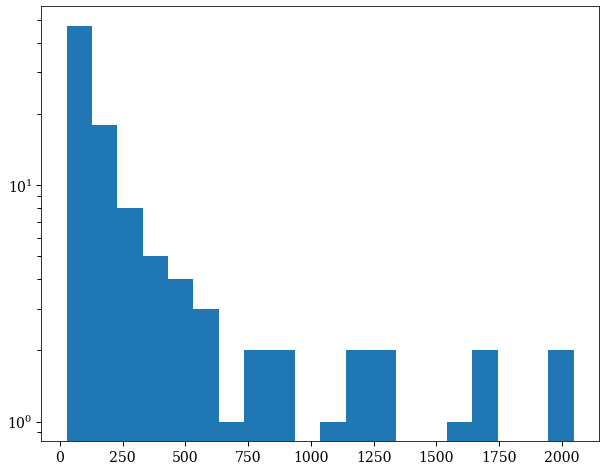

In [6]:
plt.hist(event_df["Events"], bins=20)
plt.yscale('log')

plt.show() 

In [7]:
# Define chi^2
def chi_square(param):
    sin2theta, dm2 = param 
    energy, cosdec, events = event_df["Energy"], event_df["cosdec"], event_df["Events"]
    f_x = atmo_event_rate(energy, cosdec, sin2theta, dm2)
    chi2 = np.sum((events - f_x)**2 / f_x) #because sigma = sqrt(f_x)
    return chi2

In [8]:
# Minimise the chi^2
sin2theta = 0.9
dm2 = 2.4e-3
model = scipy.optimize.minimize(chi_square, x0 = [sin2theta, dm2],  bounds=[(0,1), (0,1)])
print(model)

      fun: 95.75916569481785
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01994067, 18.72322599])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 99
      nit: 18
     njev: 33
   status: 0
  success: True
        x: array([0.89777645, 0.00240876])


In [9]:
# Creating a normalised histogram of chi^2
N = 1000
chi_square_array = []

for i in range(N):
    event_df = generate_experiment()
    def chi_square(param):
        sin2theta, dm2 = param 
        energy, cosdec, events = event_df["Energy"], event_df["cosdec"], event_df["Events"]
        f_x = atmo_event_rate(energy, cosdec, sin2theta, dm2)
        chi2 = np.sum((events - f_x)**2 / f_x) #because sigma = sqrt(f_x)
        return chi2
    
    model = scipy.optimize.minimize(chi_square, x0 = [sin2theta, dm2],  bounds=[(0,1), (0,1)])
    if model["success"] == True and model["fun"] >= 0:
        chi_square_array.append(model["fun"])

(array([0.0002862 , 0.00114481, 0.00143102, 0.00429305, 0.00801369,
        0.01287914, 0.0177446 , 0.02289625, 0.02203764, 0.02890652,
        0.02862032, 0.03033754, 0.02032043, 0.01974802, 0.01574117,
        0.01202053, 0.00715508, 0.00457925, 0.00257583, 0.00228963,
        0.00200342, 0.00085861, 0.0002862 , 0.00057241, 0.0002862 ]),
 array([ 58.0966524 ,  61.84158408,  65.58651577,  69.33144745,
         73.07637913,  76.82131082,  80.5662425 ,  84.31117418,
         88.05610587,  91.80103755,  95.54596923,  99.29090092,
        103.0358326 , 106.78076429, 110.52569597, 114.27062765,
        118.01555934, 121.76049102, 125.5054227 , 129.25035439,
        132.99528607, 136.74021775, 140.48514944, 144.23008112,
        147.9750128 , 151.71994449]),
 <BarContainer object of 25 artists>)

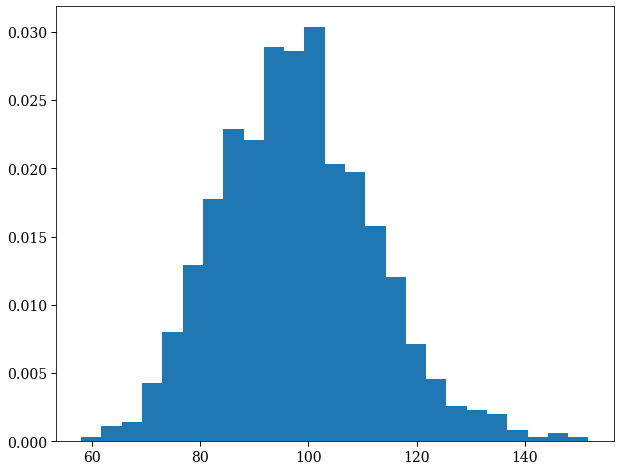

In [10]:
plt.hist(chi_square_array, density = True, bins = 25)

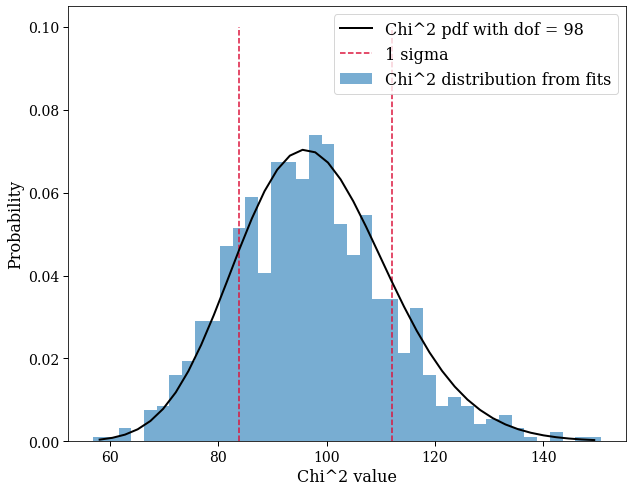

Mean of chi^2 values: 97.91
Std. dev of chi^2 values: 14.12
Variance of chi^2 values: 199.50


In [53]:
bins = 40
dof=98

bin_height, bin_boundary = np.histogram(chi_square_array, bins=bins)
width = bin_boundary[1]-bin_boundary[0]
bin_height = bin_height/np.sum(bin_height)

chi2_func = stats.chi2.pdf(bin_boundary[:-1], df=(dof))
plt.bar(bin_boundary[:-1],bin_height, width = width, alpha=0.6, label="Chi^2 distribution from fits")
plt.plot(bin_boundary[:-1], chi2_func*(dof/bins), label=f"Chi^2 pdf with dof = {int(dof)}", c = 'k', lw = 2)

plt.vlines([np.mean(chi_square_array) + np.std(chi_square_array), np.mean(chi_square_array) - np.std(chi_square_array)], 0, 0.1, color="crimson", label="1 sigma", ls="--")
plt.xlabel("Chi^2 value")
plt.ylabel("Probability")
plt.legend()
plt.show()

print(f"Mean of chi^2 values: {np.mean(chi_square_array):.2f}")
print(f"Std. dev of chi^2 values: {np.std(chi_square_array):.2f}")
print(f"Variance of chi^2 values: {np.var(chi_square_array):.2f}")

In [39]:
# Now find the delta chi^2 = chi ^2 - chi_min^2, where ellipse contains 67% of data points

chi_square_sorted = np.sort(chi_square_array)
chi_len = len(chi_square_sorted)
chi_67_idx = np.around(chi_len*0.67)
chi_min = np.min(chi_square_sorted)
chi_67 = chi_square_sorted[int(chi_67_idx)]

delta_chi_square = chi_67 - chi_min
delta_chi_square

44.96840290279973

# COVID-19 self-testing and Bayesian theorem

Using Bayes' Theorem, the probability of A occurring given B is:
$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Where $P(B)$ is the probability of B occurring, and $P(B|A)$ is the probability of B occurring given A.

Type I error (false positive): The probability of a covid-negative person testing positive $P(T+|C-)$ is 1%.

Type II error (false negative): The probability of a covid-positive person testing negative $P(T-|C+)$ is 40%.

The probability of a covid-positive person testing positive $P(T+|C+)$ is 60%.

The probability of being covid-negative given a positive test is:
$$ P(C-|T+) = \frac{P(T+|C-)P(C-)}{P(T+)}  =  \frac{P(T+|C-)P(C-)}{P(T+|C-)P(C-) + P(T+|C+)P(C+)}$$

$$ P(C-) = 1 - P(C+),$$
where $P(C+)$ is the covid prevalence.

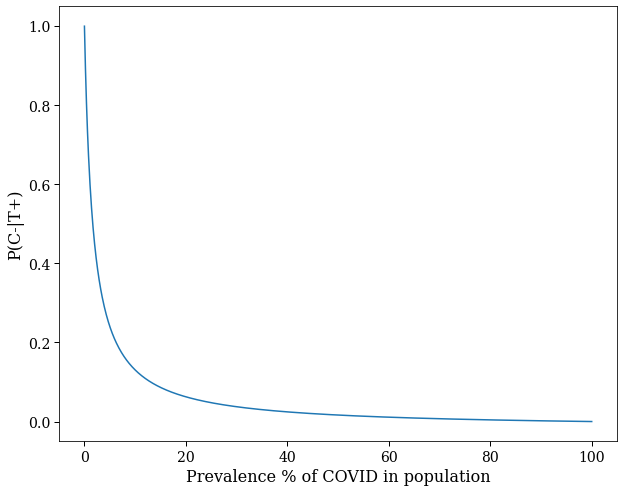

In [46]:
p_sick = np.linspace(1e-6,1,1000) # array of different COVID prevalences

p_positive_sick = 0.6
p_positive_healthy = 0.01

def p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy):
    num = (1-p_sick) * p_positive_healthy
    den = p_sick*(p_positive_sick-p_positive_healthy) + p_positive_healthy
    return num/den

plt.plot(p_sick*100, p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy))
plt.xlabel("Prevalence % of COVID in population")
plt.ylabel("P(C-|T+)")
plt.show()

The probability of being healthy given a negative test:

$$ P(C-|T-) = \frac{P(T-|C-)P(C-)}{P(T-)}  = \frac{P(T-|C-)P(C-)}{P(T-|C-)P(C-) + P(T-|C+)P(C+)} $$

and once again using 
$$ P(C-) = 1 - P(C+)$$

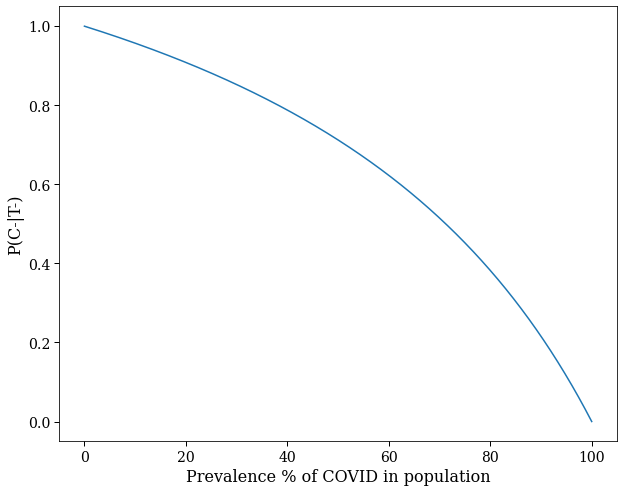

In [47]:
def p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy):
    num = (1-p_sick) * (1-p_positive_healthy)
    den = ((1-p_positive_sick)-(1-p_positive_healthy)) * p_sick + (1-p_positive_healthy)
    return num/den

plt.plot(p_sick*100, p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy))
plt.xlabel("Prevalence % of COVID in population")
plt.ylabel("P(C-|T-)")
plt.show()

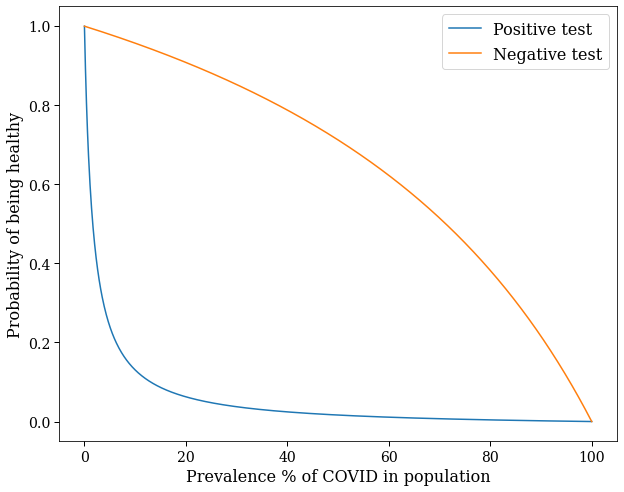

In [49]:
plt.plot(p_sick*100, p_healthy_positive(p_sick, p_positive_sick, p_positive_healthy), label="Positive test")
plt.plot(p_sick*100, p_healthy_negative(p_sick, p_positive_sick, p_positive_healthy), label="Negative test")

plt.ylabel("Probability of being healthy")
plt.xlabel("Prevalence % of COVID in population")
plt.legend()
plt.show()